# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [52]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

import numpy.linalg as alg

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [53]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [54]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [55]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [56]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [57]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [58]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

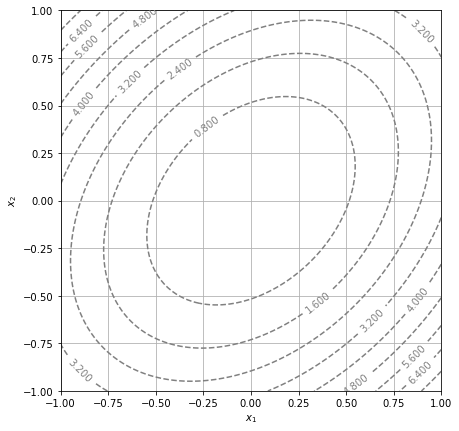

In [59]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [60]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

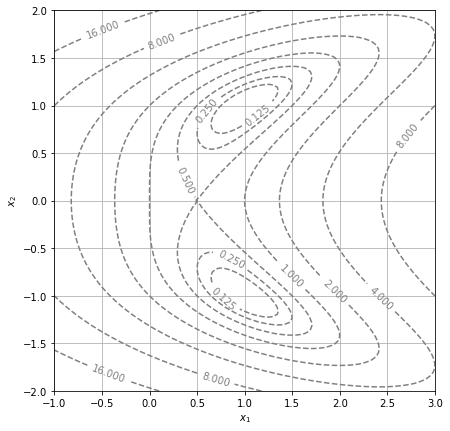

In [61]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [62]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

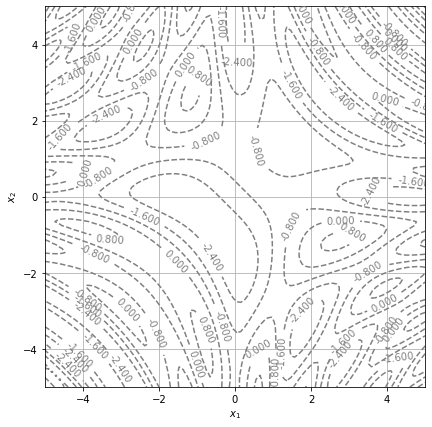

In [63]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [64]:
N = 100
eps = 1e-10

**Réponse** La valeur de eps résulte d'un compromis entre la précision souhaitée (permise par la précision de la fonction Newton avec N=100 points) et l'erreur d'arrondie liée aux flottants.

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [65]:
def Newton(F, x0, y0, eps=eps, N=N):
    JF = J(F)
    for i in range(N):
        X0 = np.array([x0,y0])
        X = X0-(alg.inv(JF(x0,y0))).dot(F(x0,y0))
        x, y = X[0], X[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [66]:
def f1_test(x,y):
    return np.array([f1(x,y)-0.8,x-y])

Newton(f1_test,0.8,0.8)

(0.4472135954999579, 0.4472135954999579)

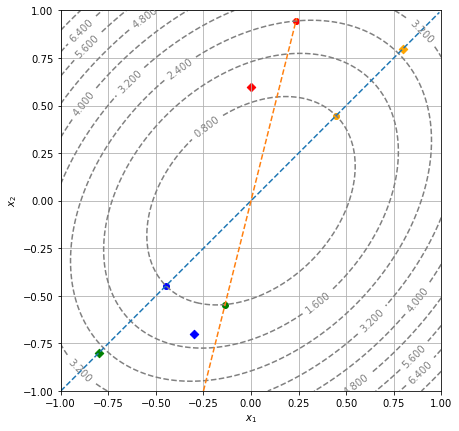

In [67]:
a1,b1=0.8,0.8
a2,b2=Newton(f1_test,a1,b1)

a3,b3=-0.3,-0.7 #on modifie le point de départ
a4,b4=Newton(f1_test,a3,b3)

def f2_test(x,y):
    return np.array([f1(x,y)-0.8,4*x-y]) #on modifie la contrainte (y=4x)

a5,b5=-0.8,-0.8
a6,b6=Newton(f2_test,a5,b5)

def f3_test(x,y):
    return np.array([f1(x,y)-2.4,4*x-y]) #on modifie la ligne de niveau (f1(x,y)=2.4)

a7,b7=0.0,0.6
a8,b8=Newton(f3_test,a7,b7)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)

#le point de départ est représenté par un losange et celui d'arrivée par un point de la même couleur.
plt.scatter(a1, b1,color = 'orange', marker = 'D')
plt.scatter(a2, b2, color = 'orange')

plt.scatter(a3, b3,color = 'blue', marker = 'D')
plt.scatter(a4, b4, color = 'blue')

plt.scatter(a5, b5,color = 'green', marker = 'D')
plt.scatter(a6, b6, color = 'green')

plt.scatter(a7, b7,color = 'red', marker = 'D')
plt.scatter(a8, b8, color = 'red')

x1 = np.arange(-1,1,0.01)
x2 = np.arange(-1/4,1/4,0.01)
y = 4*x2
plt.plot(x1,x1,linestyle='dashed')
plt.plot(x2,y,linestyle='dashed')

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

**Résolution** On raisonne en deux étapes.

- En partant du point $(x_0,y_0)$, on construit un nouveau vecteur orthogonal à celui-ci dans le sens "vers la droite" et on lui donne une norme $\delta $
- On lui applique ensuite la méthode de Newton en considérant la fonction $F(x,y) = (f(x,y)-c, (x-x_0)^2+(y-y_0)^2-\delta^{2})$

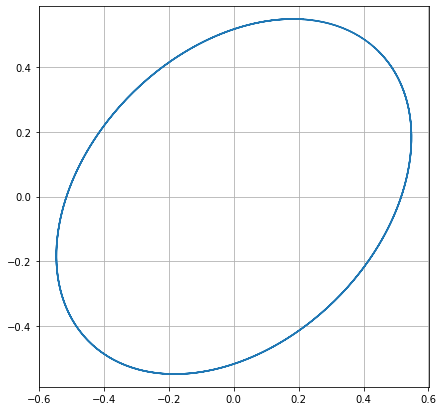

In [89]:
def level_curve(f, x0, y0, delta=0.01, N=1000, eps=eps):
    res = [[x0,y0]]
    c = f(x0,y0)
    grad_f = grad(f)
    for k in range(N-1):
        X0 = np.array([x0,y0])
        a, b = grad_f(x0,y0)[0], grad_f(x0,y0)[1]
        X = X0 + np.array([b, -a])*(delta/(np.sqrt(a**2+b**2)))
        x, y = X[0], X[1]
        def F(x,y):
            return np.array([f(x,y)-c,(x-X0[0])**2+(y-X0[1])**2-delta**2])
        x, y = Newton(F, x, y)
        x0, y0 = x, y
        res.append([x, y])
    return np.transpose(np.array(res))

p = level_curve(f1,0.4472135954999579,0.4472135954999579)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()


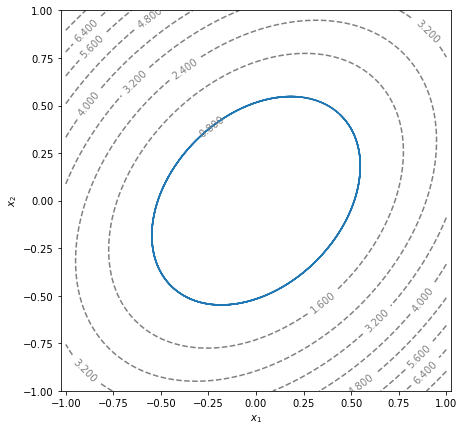

In [90]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Réponse** On impose une condition supplémentaire, lorsque qu'un point de la courbe de niveau est à une distance inférieure à $\delta $ du point de départ on s'arrête à la fin de l'éxécution de la boucle. 

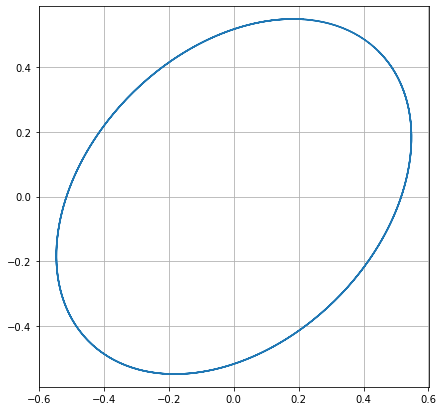

In [91]:
def level_curve_bis(f, x0, y0, delta=0.01, N=1000, eps=eps):
    res = [[x0,y0]]
    c = f(x0,y0)
    d, e = x0, y0
    grad_f = grad(f)
    n = 0
    for k in range(N-1):
        X0 = np.array([x0,y0])
        a, b = grad_f(x0,y0)[0], grad_f(x0,y0)[1]
        X = X0 + np.array([b, -a])*(delta/(np.sqrt(a**2 + b**2)))
        x, y = X[0], X[1]
        def F(x,y):
            return np.array([f(x,y)-c,(x-X0[0])**2 + (y-X0[1])**2- delta**2])
        x, y = Newton(F, x, y)
        x0, y0 = x, y
        res.append([x, y])
        if np.sqrt((x-d)**2+(y-e)**2) < (delta-1e-8):
            break
    return np.transpose(np.array(res))

p = level_curve(f1,0.4472135954999579,0.4472135954999579)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

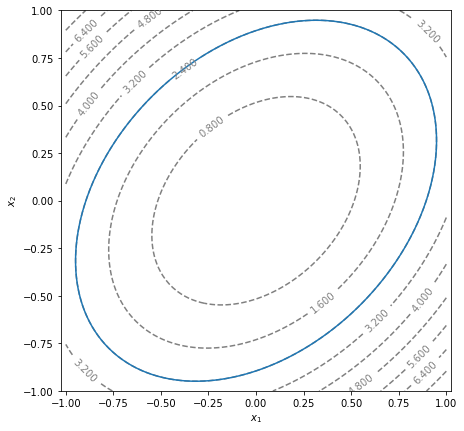

In [92]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

def F(x,y):
    return np.array([f1(x,y) - 2.4, 3*x - y])

a, b = Newton(F,1.,0.5)

p = level_curve_bis(f1, a, b)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()

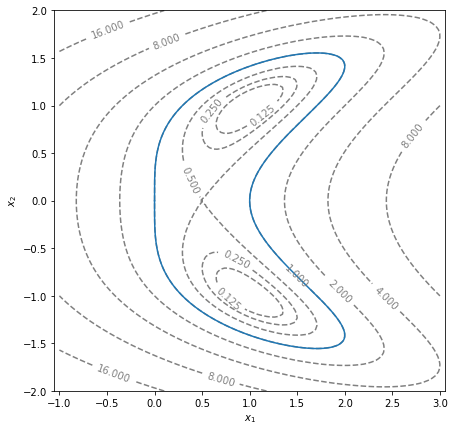

In [72]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
def F(x,y):
    return np.array([f2(x,y) - 1, 3*x - y])

a, b = Newton(F,1.,0.5)

p = level_curve_bis(f2, a, b)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()

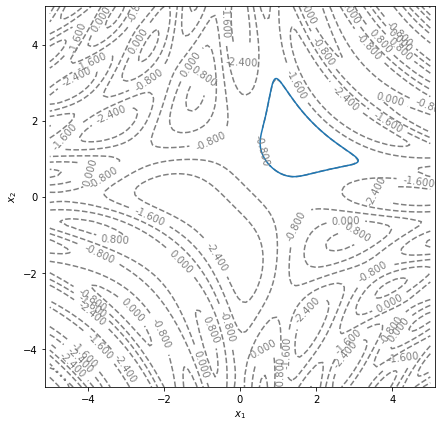

In [93]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

def F(x,y):
    return np.array([f3(x,y) + 0.8, x - y])

a, b = Newton(F,0.1,0.)

p = level_curve_bis(f3, a, b)
plt.axis('equal')
plt.plot(p[0], p[1])
plt.grid()
plt.show()

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [74]:
def area_squares(f,c,h,xinf,yinf,l): 
#xinf et yinf sont l'abscisse et l'ordonnée inférieures du carré et l la longueur de son côté
    n=0
    for i in range(int(l/h)):
        for j in range(int(l/h)):
            if f(xinf+h/2+j*h,yinf+h/2+i*h)<=c:
                n+=1
    return n*h*h

In [75]:
def f(x,y):
    return x**2+y**2

#on fixe au préalable l'abscisse et l'ordonnée inférieures ainsi que le côté du carré d'origine  
xinf=-1.0
yinf=-1.0
l=2.0
print(area_squares(f, 1.0, 0.01, xinf, yinf, l)) #calcul de l'aire du cercle unité 

3.1428000000000003


régression linéaire: y= 1.3750672085664357 x + -0.336770831886383


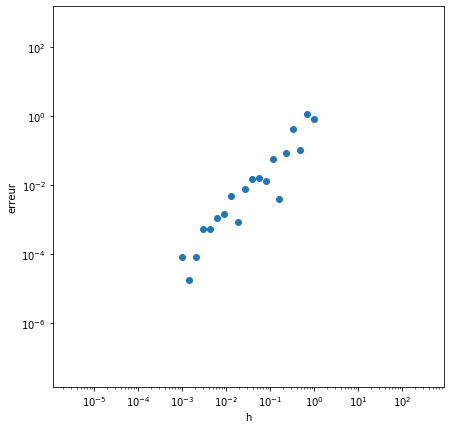

In [94]:
def erreur(h):
    return abs(np.pi-area_squares(f, 1.0, h, xinf, yinf, l))

X=np.linspace(0,3,20)
Xbis=[10**(-i) for i in X]
Y=[erreur(i) for i in Xbis]

plt.yscale('log')
plt.ylabel('erreur')

plt.xscale('log')
plt.xlabel('h')

plt.scatter(Xbis,Y)

#régression linéaire
a, b = np.polyfit(np.log(np.array(Xbis)), np.log(np.array(Y)), 1)
print("régression linéaire: y=",a,"x +",b)
plt.show()

On propose un code alternatif qui permette  dans certains cas bien précis (exemple de la fonction f1) de s'affranchir des renseignements sur le carré d'origine en exploitant la fonction `Newton` et  `level_curve_bis`

In [77]:
def area_squares_bis(f,c,h):
    def F(x,y):
        return np.array([f(x,y)-c,x-y])
    x, y = Newton(F, 1., 0.5)
    a, b = level_curve_bis(f, x, y)
    L = (1/2)*max(max(a)-min(a), max(b)-min(b))
    x0, y0 = (1/2)*(min(a)+max(a)), (1/2)*(min(b)+max(b))
    n = 0
    for i in range(int((2*L)/h)):
        for j in range(int((2*L)/h)):
            if f(x0-L+h/2+j*h,y0+L-h/2-i*h)<=c:
                n+=1
    return n*h*h

In [78]:
print(area_squares_bis(f1,0.8,0.01))

0.8875000000000001


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


**Réponse** Lorsqu'on parcourt les carrés de côté h, on distingue deux cas.

1) Si le centre du carré n'est pas dans K, on regarde si l'un de ses quatre coins est effectivement dans K et si c'est le cas on ajoute son aire au compteur air_sup.

2) Si le centre du carré est dans K, on ajoute son aire au compteur air_sup. De plus, si ses quatre coins le sont aussi, on ajoute son aire au compteur air_inf.

Ce procédé permet de s'assurer que a_sup et a_inf sont respectivement supérieures et inférieures à la vraie aire. 

In [79]:
def area_squares_encadrement(f,c,h):
    a_inf=0
    a_sup=0
    for i in range(int(l/h)):
        for j in range(int(l/h)):
            x=xinf+h/2+j*h
            y=yinf+h/2+i*h
            
            #On teste les quatre coins du carré
            C1=f(x+h/2,y+h/2)<=c
            C2=f(x+h/2,y-h/2)<=c
            C3=f(x-h/2,y-h/2)<=c
            C4=f(x-h/2,y+h/2)<=c
            
            if f(x,y)>c: #si le carré n'est pas dans K
                if C1 or C2 or C3 or C4:
                        a_sup+=h**2
                        
            elif f(x,y)<=c: #si le carré est dans K 
                a_sup+=h**2
                if C1 and C2 and C3 and C4:
                    a_inf+=h**2
                   
    return a_inf,a_sup

print(area_squares_encadrement(f,1.0,0.001))

(3.1375480000846556, 3.145528000085771)


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [95]:
def triangles_test(delta, f, a, b, x0, y0):
#a,b sont les coordonnées du point p;
#x0,y0 sont les coordonnées du point de départ de level_curve
    contour=level_curve_bis(f, x0, y0, delta, N=1000, eps=eps)
    B_N=0
    for i in range(len(contour[0])-1):
        #on prend les coordonnées de z_i et z_i+1
        x,y=contour[0,i],contour[1,i]
        xsuiv,ysuiv=contour[0,i+1],contour[1,i+1]
        #on calcule l'aire des petits triangles grâce à la formule du déterminant
        B_i = -(1/2)*((x-a)*(ysuiv-b)-(xsuiv-a)*(y-b))
        B_N+=B_i
    #on rajoute le dernier triangle
    x,y=contour[0,-1],contour[1,-1]
    xsuiv,ysuiv=contour[0,0],contour[1,0]
    B_N+= -(1/2)*((x-a)*(ysuiv-b)-(xsuiv-a)*(y-b))
    return B_N

a,b=0,0 #coordonées du point p (ici le centre du cercle)
x0,y0 = 0.,1.
def f(x,y):
    return x**2+y**2   
print(triangles_test(0.01,f, a, b, x0, y0))

3.141540317236532


régression linéaire: y= 2.000556759179658 x + -0.6480813154883186


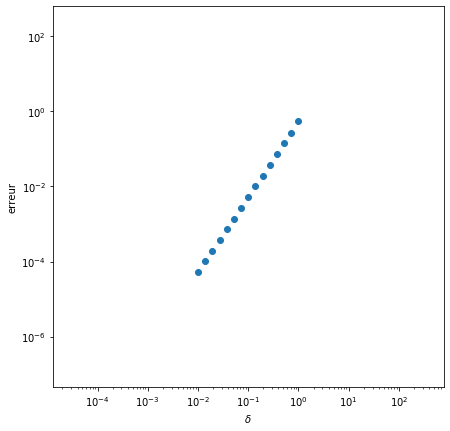

In [96]:
def erreur(delta):
    return abs(np.pi-triangles_test(delta, f, a, b, x0, y0))

X=np.linspace(0,2,15)
Xbis=[10**(-i) for i in X]
Y=[erreur(i) for i in Xbis]

plt.xscale('log')
plt.xlabel('$\delta$')

plt.yscale('log')
plt.ylabel('erreur')

plt.scatter(Xbis,Y)
a, b = np.polyfit(np.log(np.array(Xbis)), np.log(np.array(Y)), 1)
print("régression linéaire: y=",a,"x +",b)
plt.show()

**Remarque** On décide d'étudier l'erreur pour une valeur de $\delta$ allant jusqu'à $10^{-2}$. Il est possible de se rapprocher encore plus de 0, mais cela impliquerait d'augmenter la valeur de N (en effet plus on diminue la distance entre deux points plus le nombre de points nécessaires pour réaliser le contour est important). Nous avons fait le choix de ne pas modifier N ici.

La vitesse de convergence logarithmique est ici de 2 environ, on remarque qu'elle est supérieure à la convergence de la méthode des carrés.

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Réponse** On remarque avec nos exemples ci-dessous que les résultats sont proches que le point soit à l'intérieur ou à l'extérieur.
D'après la formule du calcul de l'aire de notre fonction ``triangles_test`` l'aire du triangle est comptée positivement lorsque l'angle entre $(x_k,y_k)-p$ et $(x_k+1,y_k+1)-p$ est positif dans le sens anti-trigonométrique. 
Lorsque le point $p$ est placé à l'extérieur de $K$, l'aire de certains triangles qui dépassent de la figure qui sont comptés positivement seront compensés par des triangles dont l'aire est comptée négativement. On peut montrer que pour trois points $a_0$, $a_1$, $a_2$ l'aire calculée dans la fonction triangles_test ne dépend pas du point $p$ choisi. On suppose que la démonstration pourra se généraliser pour un nombre N de points. Notons $S$ l'aire calculée:

$
S = -1/2*det(a_0-p,a_1-p)-1/2*det(a_1-p,a_2-p)-1/2*det(a_2-p,a_0-p)\\
S = -1/2*(det(a_0-p,a_1-p)+det(a_2-p,a_0-a_1)\\
S = -1/2*(det(a_0-p,a_1-a_0)+det(a_0-p,a_0-p)+det(a_2-p,a_0-a_1))\\
S = -1/2*(det(a_2-a_0,a_0-a_1))\\
S = 1/2*det(a_2-a_0, a_1-a_0)\\
$

Cette dernière quantité est bien indépendante de $p$

In [97]:
a, b = 2, 0
print(triangles_test(0.01, f, a, b, 0., 1.))

a, b = 10, 10
print(triangles_test(0.01, f, a, b, 0., 1.))

3.141540317236564
3.141540317236604


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Réponse** La surface de niveau de la fonction $g$ pour $c=1$ correspond bien à l'union de deux disques de rayon 1 et de centres $(0,0)$ et $(3,0)$. 

In [98]:
def g(x,y):
    return min(x**2+y**2,(x-3)**2+y**2)

def triangles_test_non_convexe(delta, f, a, b,):
#a,b sont les coordonnées du point p;
#x0,y0 sont les coordonnées du point de départ de level_curve
    contour1 = level_curve_bis(f, 1., 0., delta, N=1000, eps=eps) #cercle de centre (0,0) et de rayon 1
    contour2 = level_curve_bis(f, 4., 0., delta, N=1000, eps=eps) #cercle de centre (3,0) et de rayon 1
    contour = np.concatenate((contour1,contour2), axis=1) #courbe de niveau correspondant à la réunion des deux cercles
    B_N=0
    for i in range(len(contour[0])-1):
        #on prend les coordonnées de z_i et z_i+1
        x,y=contour[0,i],contour[1,i]
        xsuiv,ysuiv=contour[0,i+1],contour[1,i+1]
        #on calcule l'aire des petits triangles grâce à la formule du déterminant
        B_i = -(1/2)*((x-a)*(ysuiv-b)-(xsuiv-a)*(y-b))
        B_N+=B_i
    #on rajoute le dernier triangle
    x,y=contour[0,-1],contour[1,-1]
    xsuiv,ysuiv=contour[0,0],contour[1,0]
    B_N+= -(1/2)*((x-a)*(ysuiv-b)-(xsuiv-a)*(y-b))
    return B_N

triangles_test_non_convexe(0.01, g, 0., 0.)

6.2830806344731

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

méthode des triangles: 6.284667687073961
méthode des carrés: 6.2856000000000005


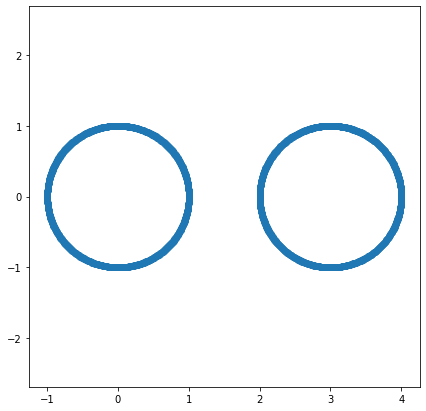

In [99]:
def area_triangles(x,y,a,b):
    B_N=0
    for i in range(len(x)-1):
        #on prend les coordonnées de z_i et z_i+1
        xi, yi= x[i], y[i]
        xsuiv, ysuiv= x[i+1], y[i+1]
        #on calcule l'aire des petits triangles grâce à la formule du déterminant
        B_i = -(1/2)*((xi-a)*(ysuiv-b)-(xsuiv-a)*(yi-b))
        B_N+=B_i
    #on rajoute le dernier triangle
    xi, yi = x[-1], y[-1]
    xsuiv,ysuiv= x[0], y[0]
    B_N+= -(1/2)*((xi-a)*(ysuiv-b)-(xsuiv-a)*(yi-b))
    return B_N

a1 = level_curve_bis(g,1.,0.,0.01)
a2 = level_curve_bis(g,3.,1.,0.01)
a3 = np.concatenate((a1,a2),axis = 1)
plt.scatter(a3[0],a3[1])
plt.axis("equal")
print("méthode des triangles:",area_triangles(a3[0], a3[1], 1.5, 1.))
print("méthode des carrés:",area_squares(g, 1, 0.01, -1., -1., 5.))

### Arguments théoriques

**Réponse** On note bien que les résultats sont cohérents avec le résultat théorique souhaité $2π$. La méthode des carrés a l'avantage d'être simple à implémenter et de pouvoir donner un encadrement du résultat, cependant on constate qu'il est difficile d'évaluer l'erreur de cette méthode car même si la tendance générale de la courbe d'erreur ressemble à une droite, on constate qu'il y a une dispersion des points autour de celle-ci. Sa complexité est en $O((l/h)^2)$, ce qui nous contraint à ne pas pouvoir prendre h trop petit sinon le nombre d'itération augmente trop. La méthode des triangles certes plus complexe à implémenter a une précision supérieure et a en plus une erreur facile à évaluer, on a une relation affine en échelle logarithmique entre l'erreur et le pas. Cependant elle nécessite une connaissance précise de la courbe de niveau par l'intermédiaire de la fonction level_curve_bis. Sa complexité est en $O(n)$ avec n le nombre de points de la courbe de niveau. Toutefois il faut prendre aussi prendre en compte la complexité de level_curve_bis pour avoir aussi accès à la donnée de la courbe de niveau.

### Tests numériques

méthode des triangles: 0.8885242888039815
méthode des carrés: 0.8898


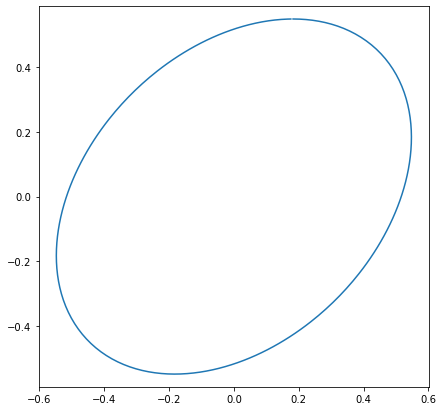

In [100]:
def F1(x,y):
    return np.array([f1(x,y) - 0.8, 3*x - y])
a, b = Newton(F1,1.,0.5)
a1 = level_curve_bis(f1, a, b)
plt.plot(a1[0],a1[1])
plt.axis("equal")

print("méthode des triangles:",area_triangles(a1[0], a1[1], 1.5, 1.))
print("méthode des carrés:",area_squares(f1, 0.8, 0.01, -1., -1., 2.))

méthode des triangles: 3.6726674627483398
méthode des carrés: 3.672


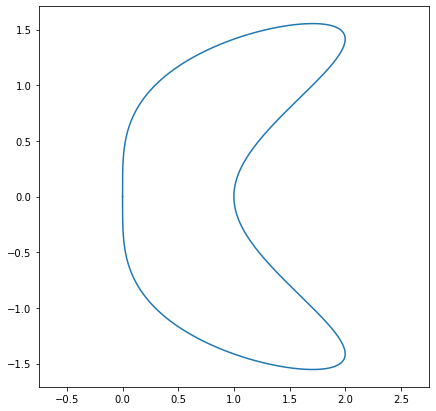

In [102]:
def F2(x,y):
    return np.array([f2(x,y) - 1, 3*x - y])
a, b = Newton(F2,1.,0.5)
p = level_curve_bis(f2, a, b)
plt.plot(p[0], p[1])
plt.axis("equal")

print("méthode des triangles:", area_triangles(p[0], p[1], 0., 0.))
print("méthode des carrés:", area_squares(f2, 1., 0.01, -1., -2., 4.))

Comparaison des temps d'éxécution pour l'exemple ci-dessus:

In [87]:
%%timeit
area_triangles(p[0], p[1], 0., 0.)

5.71 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
%%timeit
area_squares(f2, 1., 0.01, -1., -2., 4.)

401 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
